In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import supervision as sv
import torch
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/MSBuildings')
from build_seg_utils import building_gdf, rel_bbox_coords, rel_polyg_coord, segment_buildings
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/MSRoads')
from road_seg_utils import rel_road_lines, segment_roads, line2points, get_offset_lines, clear_roads, plotPoints, rmv_pts_out_img
import json


In [2]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/vaschetti/maxarSrc/creating_labels/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda:0')

predictor = SamPredictor(sam)

In [3]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif')
sample_size = 600
stride = 400
sampler = MyGridGeoSampler(dataset, size=sample_size, stride=stride)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
dataset_crs = dataset.crs
dataset_res = dataset.res

Creazione dataset e indice edifici

In [4]:
gdfs_32628 = building_gdf('TheGambia', root = '/home/vaschetti/maxarSrc/creating_labels/MSBuildings', dataset_crs = dataset_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


Creazione strade

In [5]:
path = '/home/vaschetti/maxarSrc/creating_labels/MSRoads/data/AfricaWest-Full/AfricaWest-Full.tsv'
road_df = pd.read_csv(path, names =['country', 'geometry'] ,delimiter='\t')
country = 'GMB'
road_df = road_df[road_df['country'] == country]
road_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))
road_gdf = gpd.GeoDataFrame(road_df, crs=4326)
road_gdf_32628 = road_gdf.to_crs(dataset_crs)

road_point_dist = 40 #50
bg_point_dist = 40 #80
offset_distance = 25 #30

Creazione Alberi


In [96]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/GDTrees')
from tree_seg_utils import custom_img_load, filter_on_box_area_mt2, segment_from_boxes, GDboxes2SamBoxes

import groundingdino.datasets.transforms as T
GDINO_root ="/home/vaschetti/maxarSrc/creating_labels/models/GDINO"

CONFIG_PATH = os.path.join(GDINO_root, "GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

WEIGHTS_PATH = os.path.join(GDINO_root, "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

GDINO_model = load_model(CONFIG_PATH, WEIGHTS_PATH, device='cuda')

TEXT_PROMPT = 'green tree' #'house' or 'tree' or 'green tree'
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.30


/home/vaschetti/maxarSrc/creating_labels/models/GDINO/GroundingDINO_SwinT_OGC.py ; exist: True
/home/vaschetti/maxarSrc/creating_labels/models/GDINO/groundingdino_swint_ogc.pth ; exist: True
final text_encoder_type: bert-base-uncased


In [86]:
from tqdm import tqdm
from time import time

In [112]:
i = 0
deltas = []
tot_time = []
for batch in tqdm(dataloader):
    if i == 10:
        break
    timetot = time()
    #encode the image
    sample = unbind_samples(batch)[0]
    img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')

    time1 = time()
    predictor.set_image(img4Sam)
    delta_t = time() - time1
    deltas.append(delta_t)
    

    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])#get the polygon of the sampled bbox
    
    #buildings
    buildig_hits = index_MS_buildings.query(query_bbox_poly)
    #Getting the relative coordinates of the buildings boxes
    if len(buildig_hits) != 0:
        building_boxes = rel_bbox_coords(gdfs_32628.iloc[buildig_hits], query_bbox_poly.bounds, dataset_res, ext_mt=10)

        building_mask, used_boxes, used_points  =  segment_buildings(predictor, building_boxes,
                                                    img4Sam,
                                                    use_bbox=True,
                                                    use_center_points=False)
    print(building_boxes)
    #roads
    road_hits = road_gdf_32628.geometry.intersects(query_bbox_poly)
    if len(road_hits) != 0:
        queried_road_gdf_36628 = road_gdf_32628[road_hits]
        road_lines = rel_road_lines(queried_road_gdf_36628, query_bbox_poly, dataset_res)

        road_mask, road_pt_coords4Sam, road_pt_labels4Sam = segment_roads(predictor, img4Sam, road_lines,
                                                                                sample_size,
                                                                                road_point_dist = road_point_dist,
                                                                                bg_point_dist = bg_point_dist,
                                                                                offset_distance = offset_distance,
                                                                                do_clean_mask=True)
    
    #trees
    image_transformed = custom_img_load(img4Sam)
    tree_boxes, logits, phrases = predict(GDINO_model, image_transformed, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)
    if len(tree_boxes) != 0:
        keep_ix_tree_boxes = filter_on_box_area_mt2(tree_boxes, sample_size, dataset_res, max_area_mt2 = 3000)
        tree_boxes4Sam = GDboxes2SamBoxes(tree_boxes[keep_ix_tree_boxes], sample_size)
        tree_mask, used_tree_boxes, used_tree_points = segment_from_boxes(predictor, tree_boxes4Sam, img4Sam, use_bbox=True, use_center_points=False)
    tree_boxes4Sam
    tot_time.append(time() - timetot)

    i+=1
    

  0%|          | 0/1936 [00:00<?, ?it/s]

In sampler
tile_polygon:  POLYGON ((315427.24609375 1485156.25, 320156.25 1485156.25, 320156.25 1479843.75, 315394.8974609375 1479843.75, 315427.24609375 1485156.25))
[(577.0532500196457, 231.10278673171996, 657.2313597335816, 292.6192084335327), (387.3904522344589, 224.9248534187317, 465.0653100292206, 286.95098332366945), (494.81398915233615, 187.47581278839112, 574.4361228496551, 247.8225877227783), (389.0367543029785, 176.74777796325682, 468.9989934661865, 250.18651483840944), (558.6817027488709, 166.03069275741578, 608.1303087680817, 233.07788803710937), (477.21326661071777, 167.55061394882202, 540.2472999607086, 215.02609854660034), (375.2537170326233, 274.7360071609497, 430.24343349647523, 336.77966323394776), (350.1457978866577, 274.493772064209, 395.34301131896973, 328.79770578231813), (298.7672658481598, 241.659229989624, 377.2314301240921, 302.0581020477295), (366.020014128685, 225.74793485946654, 414.6515389528275, 280.2285923988342), (144.7559255443573, 192.39183607940674,

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 1/1936 [00:02<1:33:05,  2.89s/it]

tree_boxes torch.Size([8, 4])
[(177.0532500196457, 231.10278673171996, 257.23135973358154, 292.6192084335327), (292.9850026809692, 231.1467609336853, 371.6566321144104, 291.1876387947083), (-12.609547765541077, 224.9248534187317, 65.06531002922058, 286.95098332366945), (378.75403329849246, 208.9561796951294, 448.15518024864195, 266.98460253448485), (94.81398915233612, 187.47581278839112, 174.43612284965516, 247.8225877227783), (-10.963245697021485, 176.74777796325682, 68.99899346618652, 250.18651483840944), (292.4660100391388, 181.26071516189575, 371.3183071529388, 240.76331424255372), (184.4454458580017, 173.3683174293518, 266.76312124881747, 235.0023312171936), (158.68170274887086, 166.03069275741578, 208.13030876808168, 233.07788803710937), (77.21326661071777, 167.55061394882202, 140.24729996070863, 215.02609854660034), (-24.746282967376708, 274.7360071609497, 30.24343349647522, 336.77966323394776), (381.3407535240173, 160.58331960144042, 462.5573385391235, 220.94618296813965), (95.

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 2/1936 [00:05<1:33:02,  2.89s/it]

tree_boxes torch.Size([5, 4])
[(565.5236242071152, 472.160871598053, 641.4995470821381, 532.2798313262939), (546.5943504701614, 445.3748738632202, 596.3814516834259, 494.16600077285767), (577.7132839672089, 117.84564549560547, 661.3129680774689, 210.55462590637208), (480.7485689136505, 127.46288333129883, 560.376636725235, 200.58872373275756), (536.2243223653793, 110.90692322311402, 592.6746939918518, 167.21978051681518), (-21.24596670150757, 208.9561796951294, 48.15518024864197, 266.98460253448485), (-18.659246475982666, 160.58331960144042, 62.557338539123535, 220.94618296813965), (-23.790925582122803, 113.28707843856812, 59.68837522163391, 178.3543259124756), (-23.952371548843384, 65.27726413116456, 66.56172158889771, 139.54841733245848), (-17.652299294281004, 16.700632593536376, 66.44724366149903, 75.69733200531006), (124.17152624626159, 89.25197217941285, 184.09753612251282, 136.72274416732787), (317.3281532649994, 53.09767475891113, 380.7769671195984, 160.23191281280518), (101.270

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 3/1936 [00:08<1:31:54,  2.85s/it]

tree_boxes torch.Size([5, 4])
[(552.1536262916565, 434.2440597984314, 646.9548525791168, 495.69933900527957), (356.7978987243652, 579.921048236084, 445.2991208795547, 648.6271653373718), (165.52362420711518, 472.160871598053, 241.49954708213806, 532.2798313262939), (146.59435047016143, 445.3748738632202, 196.3814516834259, 494.16600077285767), (347.5525204563141, 373.2961888748169, 435.69261439247134, 449.4860809143066), (280.97819397888185, 331.3935252243042, 354.28722312469483, 404.821086656189), (288.06208668136594, 191.60964923782348, 364.56681798973085, 265.0634092842102), (177.71328396720887, 117.84564549560547, 261.3129680774689, 210.55462590637208), (80.74856891365052, 127.46288333129883, 160.376636725235, 200.58872373275756), (136.22432236537932, 110.90692322311402, 192.6746939918518, 167.21978051681518), (552.8461666942596, 330.89907683029173, 635.770556171608, 411.87359984436034), (543.0014385452271, 250.8506578804016, 599.2088584285736, 337.17393213043215), (530.32631481132

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 4/1936 [00:11<1:31:32,  2.84s/it]

tree_boxes torch.Size([11, 4])
[(387.70208513793943, 567.5820809295654, 435.0739987258911, 622.3119365577697), (282.17098229599, 540.0811197929382, 333.97416954574584, 621.679810697937), (229.72451536331178, 490.5074330116272, 320.0305412513733, 566.4244769714355), (299.40683310585024, 481.14457807540896, 376.0900727109909, 556.9234786308289), (152.1536262916565, 434.2440597984314, 246.95485257911682, 495.69933900527957), (404.5931214717865, 546.2422286636353, 478.1873321537018, 613.1326196846009), (511.751585190773, 520.8094591033936, 578.1588329776764, 592.3023749397278), (490.14042823257444, 462.46165512924193, 562.853122929573, 546.6528547225952), (562.6290188232422, 447.67684227600097, 649.0770586044312, 539.9145937820434), (402.2960315826416, 376.8625877464294, 465.6718507564545, 467.50092831726073), (492.49726736106874, 358.0432917282105, 575.6133886436462, 455.6065075042725), (-43.20210127563477, 579.921048236084, 45.29912087955475, 648.6271653373718), (-52.447479543685915, 373

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 5/1936 [00:14<1:32:40,  2.88s/it]

tree_boxes torch.Size([32, 4])
[(451.46120016555784, 572.7269101432801, 505.77163006210327, 633.2971862037658), (-12.297914862060546, 567.5820809295654, 35.073998725891116, 622.3119365577697), (256.2796247337341, 575.6234749465942, 355.9076102859497, 640.879415599823), (4.593121471786499, 546.2422286636353, 78.18733215370179, 613.1326196846009), (111.75158519077301, 520.8094591033936, 178.15883297767638, 592.3023749397278), (237.86726414031983, 495.4079860824585, 291.0080688747406, 542.3288342819213), (90.14042823257446, 462.46165512924193, 162.85312292957306, 546.6528547225952), (162.62901882324218, 447.67684227600097, 249.07705860443116, 539.9145937820434), (2.2960315826416013, 376.8625877464294, 65.67185075645446, 467.50092831726073), (92.49726736106872, 358.0432917282105, 175.61338864364623, 455.6065075042725), (249.1058194984436, 356.0173906425476, 298.4588023956299, 412.8619962272644), (-2.2016399015426638, 338.8844351379395, 42.327677427673336, 388.7784956977844), (17.2398874429

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 6/1936 [00:17<1:33:15,  2.90s/it]

tree_boxes torch.Size([56, 4])
[(566.5941367633819, 576.4741966133117, 647.0182395839691, 669.4142856941223), (51.46120016555786, 572.7269101432801, 105.77163006210327, 633.2971862037658), (203.7155544139862, 536.8995276092529, 292.5872470542908, 636.7954352119446), (248.7598143447876, 521.4610278465271, 347.70118034648897, 611.3357354881286), (206.04290592155456, 507.37388051528933, 265.9409895595551, 559.846166581726), (212.27308582649232, 445.0067950866699, 293.60068209095, 511.74170639038084), (259.69484237060544, 442.3597623664856, 304.2884827243805, 492.7798970794678), (-47.640155001449585, 295.230987878418, 31.98392934894562, 400.280775), (113.01476683387756, 323.5461253395081, 213.71631481246948, 416.9054455558777), (25.45199253158569, 331.4682287071228, 75.47734377651214, 381.7409701469421), (101.53676107654572, 323.31673834609984, 152.77390145874023, 374.77855161361697), (27.843516030502318, 265.13653348999026, 125.29849840774536, 370.1706787414551), (189.06211557922364, 275.

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 7/1936 [00:20<1:32:25,  2.87s/it]

tree_boxes torch.Size([60, 4])
[(166.59413676338195, 576.4741966133117, 247.01823958396912, 669.4142856941223), (217.10781710243225, 540.8092997138978, 315.6399372756958, 626.3184971229554), (297.18709013195036, 521.9980849952698, 391.9462711500168, 607.6206047859192), (200.6307722185135, 426.722872429657, 270.07593905658723, 502.0359305267334), (409.98570238952635, 531.1675637825012, 500.0577556499481, 599.1184304542542), (542.3468651966095, 440.380282824707, 609.7256299034119, 491.8016827270508), (367.8526412315369, 324.01547510757445, 449.90460726852416, 399.3161951156616), (369.54597740306855, 312.12757217254637, 433.0083786281586, 362.83526981887815), (234.1282380540848, 404.33616890945433, 309.29511258010865, 492.5590394302368), (291.3555287399292, 408.1800602638245, 349.9757919506073, 466.0431194160461), (183.5697060783386, 382.5789131225586, 249.6493826763153, 439.34506389160157), (277.87148762435913, 367.25898458023073, 353.49672323646547, 443.2308244995117), (238.705635346031

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 8/1936 [00:22<1:32:25,  2.88s/it]

tree_boxes torch.Size([47, 4])
[(526.0143844730377, 444.46876584014893, 601.882349048233, 538.7838823677063), (486.3668296365738, 408.5764713943481, 547.3913942733765, 482.9578544898987), (514.5154290517808, 415.4144239265442, 581.2642473705291, 475.7310181388855), (523.5040362421036, 362.74060323944093, 624.0004099079132, 463.11192537612914), (494.1599650737762, 385.70769085617064, 553.5178950500489, 439.64961772232056), (9.985702389526367, 531.1675637825012, 100.05775564994812, 599.1184304542542), (142.34686519660949, 440.380282824707, 209.72562990341186, 491.8016827270508), (208.34676576843262, 429.3859518463135, 274.24936357212067, 497.8064291267395), (288.5669163076401, 404.9327352859497, 377.25968287773134, 486.86818301849365), (-32.147358768463135, 324.01547510757445, 49.90460726852417, 399.3161951156616), (-30.45402259693146, 312.12757217254637, 33.00837862815857, 362.83526981887815), (469.9380897670746, 334.38579110946654, 545.942094263649, 421.37599503860474), (501.8726481761

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  0%|          | 9/1936 [00:25<1:32:18,  2.87s/it]

tree_boxes torch.Size([62, 4])
[(126.01438447303772, 444.46876584014893, 201.88234904823304, 538.7838823677063), (86.3668296365738, 408.5764713943481, 147.39139427337648, 482.9578544898987), (114.5154290517807, 415.4144239265442, 181.26424737052918, 475.7310181388855), (123.50403624210358, 362.74060323944093, 224.0004099079132, 463.11192537612914), (94.15996507377625, 385.70769085617064, 153.51789505004882, 439.64961772232056), (69.93808976707459, 334.38579110946654, 145.94209426364898, 421.37599503860474), (101.87264817619324, 324.34592750701904, 167.974102236557, 394.0131106513977), (60.29654065589905, 317.99990052032473, 120.93271195640564, 370.5178320953369), (239.58071870288848, 271.9133240623474, 291.2899783573151, 338.8544966171265), (275.6390217151642, 256.97746974334717, 394.173347265625, 350.68268539657595), (279.29633908195495, 42.85347620544434, 373.4777189620972, 203.9291662208557), (225.486561592865, 39.020094576263425, 294.9997209751129, 98.7959242980957), (203.088724166

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  1%|          | 10/1936 [00:28<1:32:09,  2.87s/it]

tree_boxes torch.Size([43, 4])


Plotting

In [88]:
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/utils')
from plotting_utils import show_mask, show_Linestrings, show_points, show_box, plot_comparison

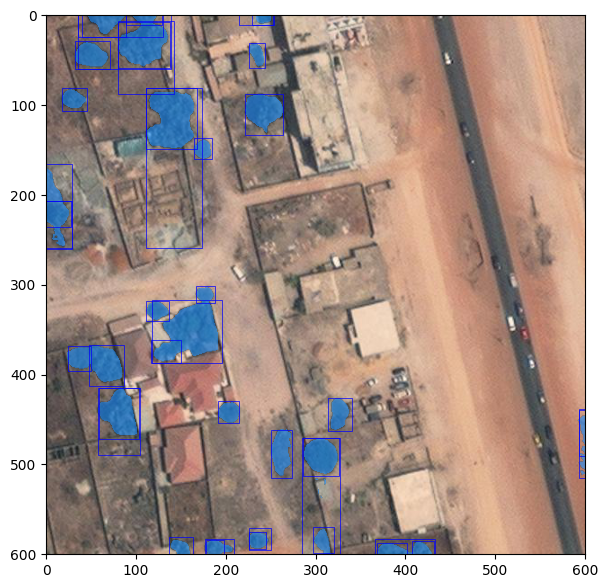

In [99]:
plot_inputs = True
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

show_mask(tree_mask, plt.gca())
#show_mask(road_mask, plt.gca(), rgb_color = [182, 112, 202])

if plot_inputs:
    #show_Linestrings(road_lines, ax, color='red')
    show_box(used_tree_boxes.tolist(), ax, color='b')
    #show_points(used_tree_points, road_pt_labels4Sam, ax)
ax.set_xlim([0, sample_size])
ax.set_ylim([sample_size, 0])
plt.show()

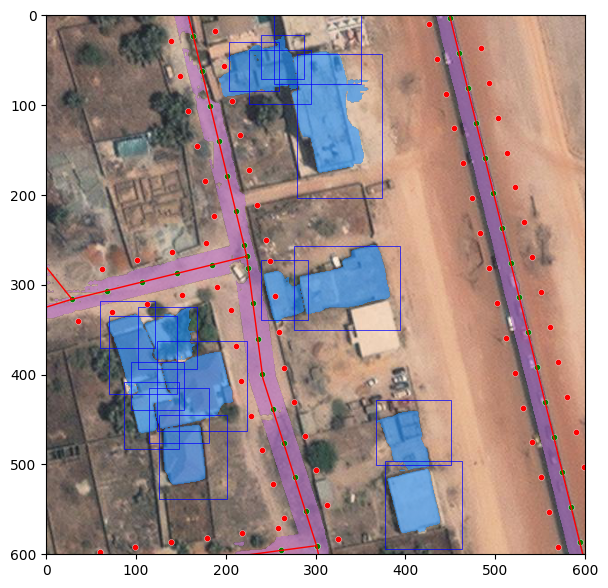

In [100]:
plot_inputs = True
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

show_mask(building_mask, plt.gca())
show_mask(road_mask, plt.gca(), rgb_color = [182, 112, 202])

if plot_inputs:
    show_Linestrings(road_lines, ax, color='red')
    show_box(used_boxes, ax, color='b')
    show_points(road_pt_coords4Sam, road_pt_labels4Sam, ax)
ax.set_xlim([0, sample_size])
ax.set_ylim([sample_size, 0])
plt.show()


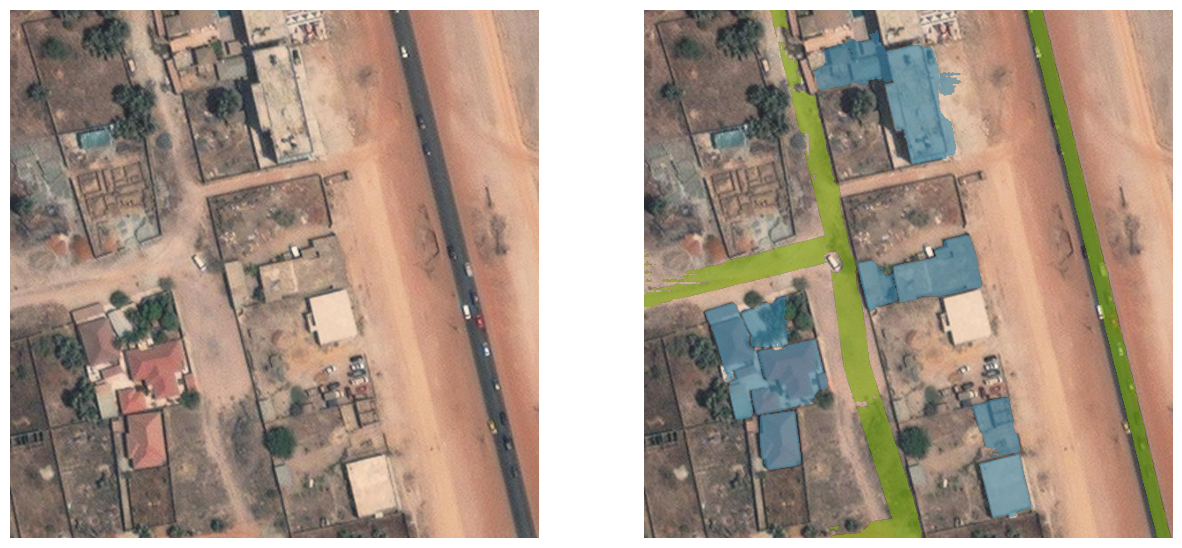

In [101]:
masks = np.vstack((building_mask, road_mask))
plot_comparison(img4Sam, masks)

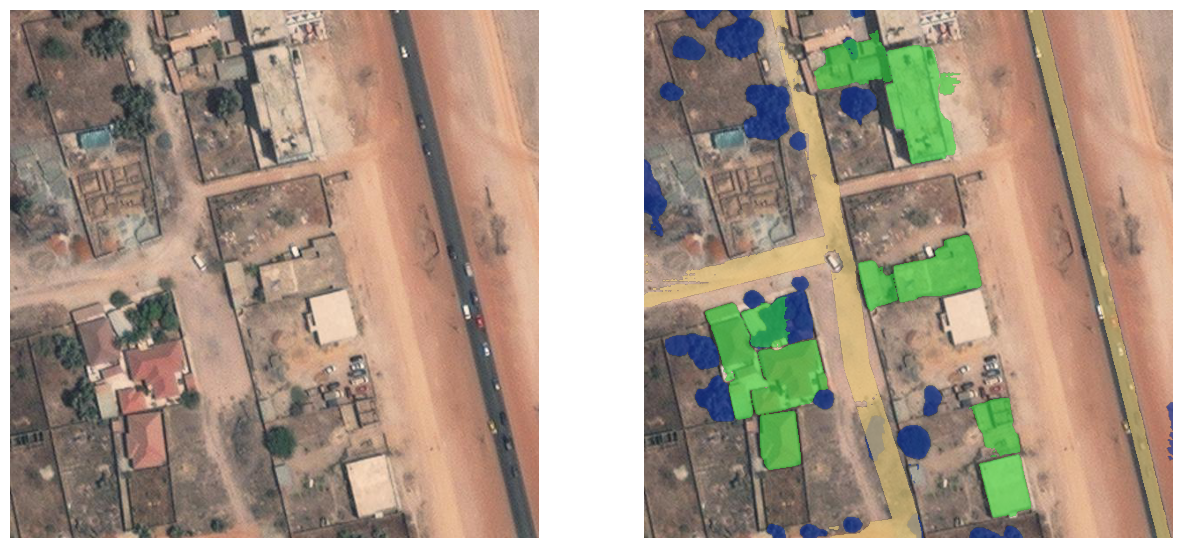

In [102]:
masks = np.vstack((tree_mask, building_mask, road_mask))
plot_comparison(img4Sam, masks)

In [82]:
img_encoding_time = np.array(deltas).mean()

In [83]:
np.array(tot_time).mean()

2.86025071144104